Using OCP to enumerate adsorbates on catalyst surfaces
======================================================

In the previous example, we constructed slab models of adsorbates on desired sites. Here we leverage code to automate this process. 

In [2]:
! rm -fr ocdata
! git clone https://github.com/Open-Catalyst-Project/Open-Catalyst-Dataset.git ocdata
! cd ocdata && pip install -e .

Cloning into 'ocdata'...
remote: Enumerating objects: 1741, done.
remote: Counting objects: 100% (433/433), done.
remote: Compressing objects: 100% (212/212), done.
remote: Total 1741 (delta 260), reused 241 (delta 221), pack-reused 1308
Receiving objects: 100% (1741/1741), 36.87 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (1081/1081), done.
Obtaining file:///home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/NRR/ocdata
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ocdata
    Found existing installation: ocdata 0.0.1
    Uninstalling ocdata-0.0.1:
      Successfully uninstalled ocdata-0.0.1
  Running setup.py develop for ocdata


In [2]:
! pip install e3nn

In [2]:
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
import ase.io
from ase.optimize import BFGS
import sys
from scipy.stats import linregress
import pickle
import matplotlib.pyplot as plt
import time

from ocdata.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
import os
from glob import glob
import pandas as pd
from ocdata.utils import DetectTrajAnomaly

# Optional - see below
import numpy as np

# Introduction

Hello All! We are so glad you could join us to learn a bit more about using OCP models to accelerate chemical simulations. We will reproduce Fig 6b from the following paper: Zhou, Jing, et al. "Enhanced Catalytic Activity of Bimetallic Ordered Catalysts for Nitrogen Reduction Reaction by Perturbation of Scaling Relations." ACS Catalysis 134 (2023): 2190-2201 (https://doi.org/10.1021/acscatal.2c05877).

To do this, we will enumerate adsorbate-slab configurations and run ML relaxations on them to find the lowest energy configuration. We will assess parity between the model predicted values and those reported in the paper. Finally we will make the figure and assess separability of the NRR favored and HER favored domains.

# Enumerate the adsorbate-slab configurations to run relaxations on

Be sure to set the path in `ocdata/configs/paths.py` to point to the correct place or pass the paths as an argument. The database pickles can be found in `ocdata/databases/pkls`. We will show one explicitly here as an example and then run all of them in an automated fashion for brevity.

In [3]:
import ocdata
from pathlib import Path
db = Path(ocdata.__file__).parent / Path('databases/pkls/adsorbates.pkl')
db

PosixPath('/home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/NRR/ocdata/ocdata/databases/pkls/adsorbates.pkl')

## Work out a single example

We load one bulk id, create a bulk reference structure from it, then generate the surfaces we want to compute.

In [4]:
bulk_src_id = "oqmd-343039"
adsorbate_smiles_nnh = "*N*NH"
adsorbate_smiles_h = "*H"

bulk = Bulk(bulk_src_id_from_db = bulk_src_id, bulk_db_path="NRR_example_bulks.pkl")
adsorbate_H = Adsorbate(adsorbate_smiles_from_db = adsorbate_smiles_h, adsorbate_db_path=db)
adsorbate_NNH = Adsorbate(adsorbate_smiles_from_db = adsorbate_smiles_nnh, adsorbate_db_path=db)
slab = Slab.from_bulk_get_specific_millers(bulk= bulk, specific_millers = (1, 1, 1))
slab

[Slab: (Ag36Pd12, (1, 1, 1), 0.16666666666666657, True)]

We now need to generate potential placements. We use two kinds of guesses, a heuristic and a random approach.

In [5]:
# Perform heuristic placements
heuristic_adslabs = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic")

# Perform random placements
# (for AdsorbML we use `num_sites = 100` but we will use 4 for brevity here)
random_adslabs = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="random_site_heuristic_placement", num_sites=4)

adslabs = [*heuristic_adslabs.atoms_list, *random_adslabs.atoms_list]
len(adslabs)

13

Let's see what we are looking at. It is a little tricky to see the tiny H atom in these figures, but with some inspection you can see there are ontop, bridge, and hollow sites in different places. This is not an exhaustive search; you can increase the number of random placements to check more possibilities. The main idea here is to *increase* the probability you find the most relevant sites.

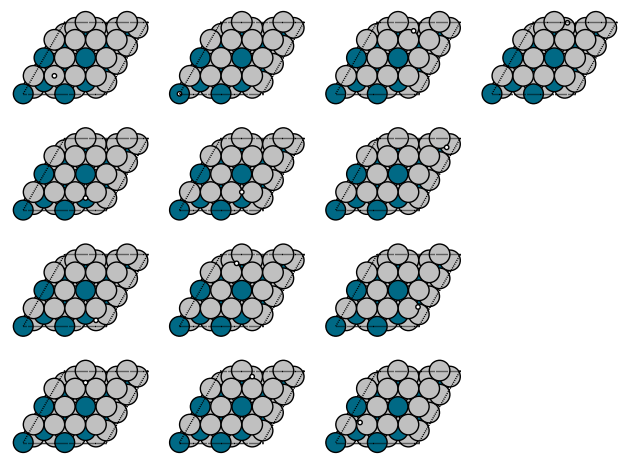

In [7]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

fig, axs = plt.subplots(4, 4)

for i, slab in enumerate(adslabs):
    plot_atoms(slab, axs[i % 4, i // 4]);
    axs[i % 4, i // 4].set_axis_off()
    
for i in range(16):
    axs[i % 4, i // 4].set_axis_off()

plt.tight_layout()   

### Run an ML relaxation

There are 2 options for how to do this.
 1. Using `OCPCalculator` as the calculator within the ASE framework
 2. By writing objects to lmdb and relaxing them using `main.py` in the ocp repo
 
(1) is really only adequate for small stuff and it is what we will show here, but if you plan to run many relaxations, you should definitely use (2). More details about writing lmdbs has been provided [here](https://github.com/Open-Catalyst-Project/ocp/blob/main/tutorials/lmdb_dataset_creation.ipynb) - follow the IS2RS/IS2RE instructions. And more information about running relaxations once the lmdb has been written is [here](https://github.com/Open-Catalyst-Project/ocp/blob/main/TRAIN.md#initial-structure-to-relaxed-structure-is2rs).

You need to provide the calculator with a path to a model checkpoint file. That can be downloaded [here](https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md).


Running the model with BFGS prints at each relaxation step is a lot to print. So we will just run one to demonstrate what happens on each iteration.

In [8]:
checkpoint_path = "../escn_l6_m3_lay20_all_md_s2ef.pt"
os.makedirs(f"data/{bulk_src_id}_{adsorbate_smiles_h}", exist_ok=True)

# Define the calculator
# calc = OCPCalculator(checkpoint=checkpoint_path, cpu=False)   # if you have a GPU
calc = OCPCalculator(checkpoint=checkpoint_path, cpu=True)

amp: false
cmd:
  checkpoint_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/NRR/checkpoints/2023-07-16-21-30-40
  commit: ab7833d
  identifier: ''
  logs_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/NRR/logs/tensorboard/2023-07-16-21-30-40
  print_every: 100
  results_dir: /home/jovyan/shared-scratch/jkitchin/tutorial/ocp-tutorial/NRR/results/2023-07-16-21-30-40
  seed: null
  timestamp_id: 2023-07-16-21-30-40
dataset: null
gpus: 0
logger: tensorboard
model: escn
model_attributes:
  basis_width_scalar: 2.0
  cutoff: 12.0
  distance_function: gaussian
  hidden_channels: 384
  lmax_list:
  - 6
  max_neighbors: 20
  mmax_list:
  - 3
  num_layers: 20
  num_sphere_samples: 128
  otf_graph: true
  regress_forces: true
  sphere_channels: 160
  use_pbc: true
noddp: false
optim:
  batch_size: 3
  clip_grad_norm: 20
  ema_decay: 0.999
  energy_coefficient: 4
  eval_batch_size: 3
  eval_every: 5000
  force_coefficient: 100
  loss_energy: mae
  loss_force: l2mae

Now we setup and run the relaxation.

In [1]:
t0 = time.time()
os.makedirs(f"data/{bulk_src_id}_H", exist_ok=True)
adslab = adslabs[0]
adslab.calc = calc
opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_H/test.traj")
opt.run(fmax=0.05, steps=100)

print(f'Elapsed time {time.time() - t0:1.1f} seconds')

NameError: name 'time' is not defined

# Run all the systems

In principle you can run all the systems now. It takes about an hour though, and we leave that for a later exercise if you want. For now we will run the first two, and for later analysis we provide a results file of all the runs. Let's read in our reference file and take a look at what is in it.

In [1]:
with open("NRR_example_bulks.pkl", "rb") as f:
    bulks = pickle.load(f)
    
bulks

NameError: name 'pickle' is not defined

We have 19 bulk materials we will consider. Next we extract the `src-id` for each one.

In [11]:
bulk_ids = [row['src_id'] for row in bulks]
bulk_ids

['oqmd-349719',
 'oqmd-345911',
 'mp-2677',
 'mp-1186014',
 'oqmd-343039',
 'oqmd-348629',
 'oqmd-343006',
 'oqmd-349813',
 'oqmd-347528',
 'oqmd-344251',
 'oqmd-343394',
 'oqmd-344635',
 'oqmd-344237',
 'oqmd-346818',
 'oqmd-349496',
 'oqmd-343615',
 'oqmd-348366',
 'oqmd-345352',
 'oqmd-346653']

In theory you would run all of these, but it takes about an hour. We just run one here. We provide the relaxation logs and trajectories in the repo for the next step.

These steps are embarrassingly parallel, and can be launched that way to speed things up. The only thing you need to watch is that you don't exceed the available RAM, which will cause the Jupyter kernel to crash.

In [ ]:
from joblib import Parallel, delayed
from tqdm import tqdm

def relax_slab(args):
    bulk_src_id, idx, label, adslab = args
    print(f'Running {bulk_src_id}_{label}/{idx}')
    adslab.calc = calc
    opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_{label}/{idx}.traj", logfile=f"data/{bulk_src_id}_{label}/{idx}.log")
    opt.run(fmax=0.05, steps=100)
    
args = []

for bulk_src_id in tqdm(bulk_ids[1:2]): 
    # Enumerate slabs and establish adsorbates
    bulk = Bulk(bulk_src_id_from_db=bulk_src_id, bulk_db_path="NRR_example_bulks.pkl")
    slab = Slab.from_bulk_get_specific_millers(bulk= bulk, specific_millers=(1, 1, 1))

    # Perform heuristic placements
    heuristic_adslabs_H = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic")
    heuristic_adslabs_NNH = AdsorbateSlabConfig(slab[0], adsorbate_NNH, mode="heuristic")
    
    #Run relaxations
    os.makedirs(f"data/{bulk_src_id}_H", exist_ok=True)
    os.makedirs(f"data/{bulk_src_id}_NNH", exist_ok=True)
    
    print(f'{len(heuristic_adslabs_H.atoms_list)} H slabs to compute for {bulk_src_id}')

    # Set up the calculator
    for idx, adslab in enumerate(heuristic_adslabs_H.atoms_list):
        args += [(bulk_src_id, idx, 'H', adslab)]

    for idx, adslab in enumerate(heuristic_adslabs_NNH.atoms_list):
        args += [(bulk_src_id, idx, 'NNH', adslab)]


t0 = time.time()
Parallel(n_jobs=4)(delayed(relax_slab)(arg) for arg in args)
print(f'{time.time() - t0:1.1f} seconds elapsed')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

9 H slabs to compute for oqmd-345911


In [ ]:
# Probably delete this cell

from tqdm import tqdm

for bulk_src_id in tqdm(bulk_ids[1:2]): 
    # Enumerate slabs and establish adsorbates
    bulk = Bulk(bulk_src_id_from_db=bulk_src_id, bulk_db_path="NRR_example_bulks.pkl")
    slab = Slab.from_bulk_get_specific_millers(bulk= bulk, specific_millers=(1, 1, 1))

    # Perform heuristic placements
    heuristic_adslabs_H = AdsorbateSlabConfig(slab[0], adsorbate_H, mode="heuristic")
    heuristic_adslabs_NNH = AdsorbateSlabConfig(slab[0], adsorbate_NNH, mode="heuristic")

    #Run relaxations
    os.makedirs(f"data/{bulk_src_id}_H", exist_ok=True)
    os.makedirs(f"data/{bulk_src_id}_NNH", exist_ok=True)

    print(f'{len(heuristic_adslabs_H.atoms_list)} H slabs to compute for {bulk_src_id}')
    print(f'{len(heuristic_adslabs_NNH.atoms_list)} NNH slabs to compute for {bulk_src_id}')

    # Set up the calculator
    for idx, adslab in enumerate(heuristic_adslabs_H.atoms_list):
        print(idx, adslab)
        adslab.calc = calc
        opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_H/{idx}.traj", logfile=f"data/{bulk_src_id}_H/{idx}.log")
        opt.run(fmax=0.05, steps=100)
        
    for idx, adslab in enumerate(heuristic_adslabs_NNH.atoms_list):
        print(idx, adslab)
        adslab.calc = calc
        opt = BFGS(adslab, trajectory=f"data/{bulk_src_id}_NNH/{idx}.traj", logfile=f"data/{bulk_src_id}_NNH/{idx}.log")
        opt.run(fmax=0.05, steps=100)

# Parse the trajectories and post-process

As a post-processing step we check to see if:

1. the adsorbate desorbed
2. the adsorbate disassociated
3. the adsorbate intercalated
4. the surface has changed

We check these because they affect our referencing scheme and may result in energies that don't mean what we think, e.g. they aren't just adsorption, but include contributions from other things like desorption, dissociation or reconstruction. For (4), the relaxed surface should really be supplied as well. It will be necessary when correcting the SP / RX energies later. Since we don't have it here, we will ommit supplying it, and the detector will instead compare the initial and final slab from the adsorbate-slab relaxation trajectory. If a relaxed slab is provided, the detector will compare it and the slab after the adsorbate-slab relaxation. The latter is more correct!

In [1]:
# Iterate over trajs to extract results
min_E = []
for file_outer in glob("data/*"):
    ads = file_outer.split("_")[1]
    bulk = file_outer.split("/")[1].split("_")[0]
    results = []
    for file in glob(f"{file_outer}/*.traj"):
        rx_id = file.split("/")[-1].split(".")[0]
        traj = ase.io.read(file, ":")

        # Check to see if the trajectory is anomolous
        detector = DetectTrajAnomaly(traj[0], traj[-1], traj[0].get_tags())
        anom = (
            detector.is_adsorbate_dissociated()
            or detector.is_adsorbate_desorbed()
            or detector.has_surface_changed()
            or detector.is_adsorbate_intercalated()
        )
        rx_energy = traj[-1].get_potential_energy()
        results.append({"relaxation_idx": rx_id, "relaxed_atoms": traj[-1],
                        "relaxed_energy_ml": rx_energy, "anomolous": anom})
    df = pd.DataFrame(results)

    df = df[~df.anomolous].copy().reset_index()
    min_e = min(df.relaxed_energy_ml.tolist())
    min_E.append({"adsorbate":ads, "bulk_id":bulk, "min_E_ml": min_e})

df = pd.DataFrame(min_E)
df_h = df[df.adsorbate == "H"]
df_nnh = df[df.adsorbate == "NNH"]
df_flat = df_h.merge(df_nnh, on = "bulk_id")

NameError: name 'glob' is not defined

# Make parity plots for values obtained by ML v. reported in the paper

In [ ]:
# Add literature data to the dataframe
with open("literature_data.pkl", "rb") as f:
    literature_data = pickle.load(f)
df_all = df_flat.merge(pd.DataFrame(literature_data), on = "bulk_id")

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(15)
x = df_all.min_E_ml_x.tolist()
y = df_all.E_lit_H.tolist()
ax1.set_title("*H parity")
ax1.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax1.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax1.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax1.scatter(x, y)
ax1.axis("square")
ax1.set_xlim([-3.5, 2])
ax1.set_ylim([-3.5, 2])
ax1.set_xlabel("dE predicted OCP [eV]")
ax1.set_ylabel("dE NRR paper [eV]");


x = df_all.min_E_ml_y.tolist()
y = df_all.E_lit_NNH.tolist()
ax2.set_title("*N*NH parity")
ax2.plot([-3.5, 2], [-3.5, 2], "k-", linewidth=3)
slope, intercept, r, p, se = linregress(x, y)
ax2.plot(
    [-3.5, 2],
    [
        -3.5 * slope + intercept,
        2 * slope + intercept,
    ],
    "k--",
    linewidth=2,
)

ax2.legend(
    [
        "y = x",
        f"y = {slope:1.2f} x + {intercept:1.2f}, R-sq = {r**2:1.2f}",
    ],
    loc="upper left",
)
ax2.scatter(x, y)
ax2.axis("square")
ax2.set_xlim([-3.5, 2])
ax2.set_ylim([-3.5, 2])
ax2.set_xlabel("dE predicted OCP [eV]")
ax2.set_ylabel("dE NRR paper [eV]");
f.set_figwidth(15)
f.set_figheight(7)

# Make figure 6b and compare to literature results

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
x = df_all[df_all.reaction == "HER"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "HER"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax1.scatter(x, y,c= "r", label = "HER")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].min_E_ml_y.tolist()
y = df_all[df_all.reaction == "NRR"].min_E_ml_x.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax1.scatter(x, y,c= "b", label = "NRR")
for i, txt in enumerate(comp):
    ax1.annotate(txt, (x[i], y[i]))


ax1.legend()
ax1.set_xlabel("dE *N*NH predicted OCP [eV]")
ax1.set_ylabel("dE *H predicted OCP [eV]")


x = df_all[df_all.reaction == "HER"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "HER"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "HER"].composition.tolist()

ax2.scatter(x, y,c= "r", label = "HER")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

x = df_all[df_all.reaction == "NRR"].E_lit_NNH.tolist()
y = df_all[df_all.reaction == "NRR"].E_lit_H.tolist()
comp = df_all[df_all.reaction == "NRR"].composition.tolist()
ax2.scatter(x, y,c= "b", label = "NRR")
for i, txt in enumerate(comp):
    ax2.annotate(txt, (x[i], y[i]))

ax2.legend()
ax2.set_xlabel("dE *N*NH literature [eV]")
ax2.set_ylabel("dE *H literature [eV]")
f.set_figwidth(15)
f.set_figheight(7)